## Currents Analysis
This notebook processes and visualizes Salish Sea NEMO currents. Results are obtained from the Nowcast system through the ERDDAP server using the `xarray` library.

In [1]:
import numpy                as np
import xarray               as xr
import datetime             as dtm
import dateutil.parser      as dparser
import matplotlib.pyplot    as plt
import matplotlib           as mpl
import matplotlib.animation as animation
import scipy.io             as sio
import os
import sys
import collections
import arrow
import requests
import currents_tools       as ct
from io import StringIO
from xml.etree import cElementTree as ElementTree
from dateutil import tz
from salishsea_tools import viz_tools, tidetools, stormtools, nc_tools
from eofs.xarray     import Eof

mpl.rcParams.update({'font.size': 13})

%matplotlib inline

/home/bmoorema/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


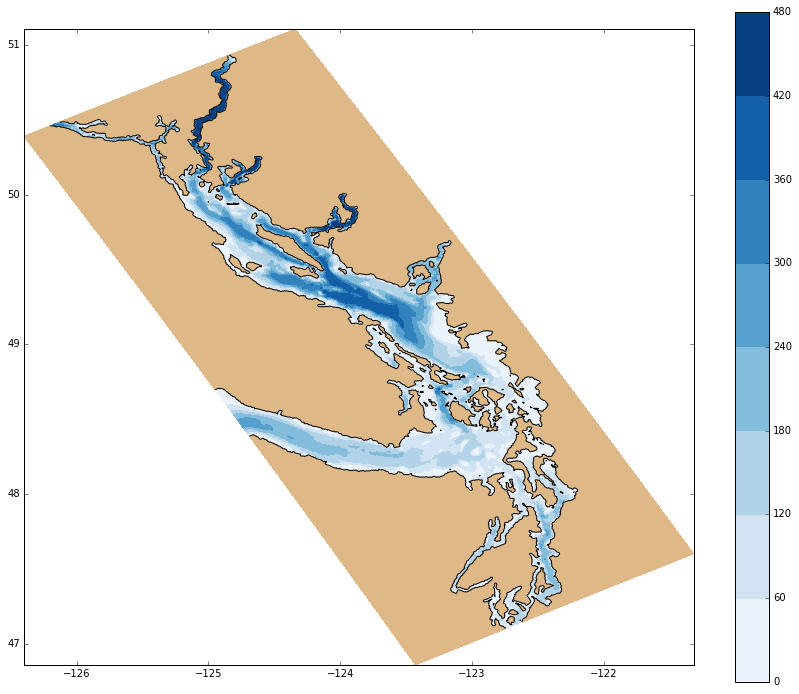

In [12]:
bathy_path = '/ocean/bmoorema/research/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
timerange = ['2016-03-01 00:00', '2016-04-01 00:00']
grid = xr.open_dataset(bathy_path)
bathy = grid.Bathymetry
grid, qty = ct.load_ERDDAP(timerange)
cmap = plt.get_cmap('Blues')
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
viz_tools.plot_land_mask(ax, bathy_path, coords='map', color='burlywood')
viz_tools.plot_coastline(ax, bathy_path, coords='map')
C = ax.contourf(grid['lon_NEMO'], grid['lat_NEMO'], bathy, cmap=cmap)
viz_tools.set_aspect(ax)
fig.colorbar(C)

fig.savefig('/ocean/bmoorema/research/MEOPAR/analysis-ben/visualization/bathymetry.eps', format='eps')

plt.show()

In [126]:
# Load EC data
PamRocks, Sandheads = {}, {}
[PamRocks['spd'], PamRocks['dir'], PamRocks['temp'], PamRocks['times'], PamRocks['lat'], PamRocks['lon']
    ] = get_EC_observations('PamRocks', '01-Mar-2016', '31-Mar-2016')
[Sandheads['spd'], Sandheads['dir'], Sandheads['temp'], Sandheads['times'], Sandheads['lat'], Sandheads['lon']
    ] = get_EC_observations('Sandheads', '01-Mar-2016', '31-Mar-2016')

# Load GEM
timerange = ['2016-03-01 00:00', '2016-04-01 00:00']
grid, qty = ct.load_ERDDAP(timerange)

# Find station indices
i_SH, j_SH = find_model_point(Sandheads['lon'], Sandheads['lat'], grid['lon_GEM'], grid['lat_GEM'])
i_PM, j_PM = find_model_point(PamRocks['lon'],  PamRocks['lat'],  grid['lon_GEM'], grid['lat_GEM'])
X_SH = grid['lon_GEM'][i_SH, j_SH].gridX.values
Y_SH = grid['lon_GEM'][i_SH, j_SH].gridY.values
X_PM = grid['lon_GEM'][i_PM, j_PM].gridX.values
Y_PM = grid['lon_GEM'][i_PM, j_PM].gridY.values

u_SH = qty['u_GEM'].sel(gridX=X_SH, gridY=Y_SH)
v_SH = qty['v_GEM'].sel(gridX=X_SH, gridY=Y_SH)
u_PM = qty['u_GEM'].sel(gridX=X_PM, gridY=Y_PM)
v_PM = qty['v_GEM'].sel(gridX=X_PM, gridY=Y_PM)

# Rotate wind
Sandheads['spd_GEM'] = np.sqrt(u_SH**2 + v_SH**2)
Sandheads['dir_GEM'] = np.arctan2(v_SH, u_SH)
Sandheads['dir_GEM'] = np.rad2deg(Sandheads['dir_GEM'] + (Sandheads['dir_GEM']<0)*2*np.pi);

PamRocks['spd_GEM'] = np.sqrt(u_PM**2 + v_PM**2)
PamRocks['dir_GEM'] = np.arctan2(v_PM, u_PM)
PamRocks['dir_GEM'] = np.rad2deg(PamRocks['dir_GEM'] + (PamRocks['dir_GEM']<0)*2*np.pi);

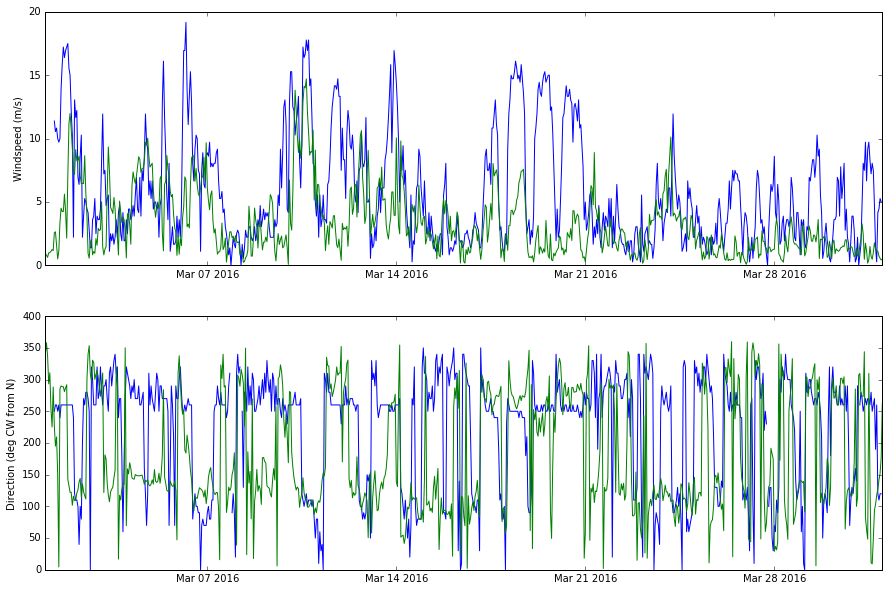

In [132]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(PamRocks['times'], PamRocks['spd'])
ax[0].plot(PamRocks['spd_GEM'].time, PamRocks['spd_GEM'])
ax[0].set_ylabel('Windspeed (m/s)')

ax[1].plot(PamRocks['times'], PamRocks['dir'])
ax[1].plot(PamRocks['dir_GEM'].time, PamRocks['dir_GEM'])
ax[1].set_ylabel('Direction (deg CW from N)')

fig.savefig('/ocean/bmoorema/research/MEOPAR/analysis-ben/visualization/wind_comparison_PM.eps', format='eps')

plt.show()

In [11]:
def get_EC_observations(station, start_day, end_day):
    """Gather Environment Canada weather observations for the station and
    dates indicated.

    The dates should span one month because of how EC data is collected.

    :arg station: Station name (no spaces). e.g. 'PointAtkinson'
    :type station: str

    :arg start_day: Start date in the format '01-Dec-2006'.
    :type start_day: str

    :arg end_day: End date in the format '01-Dec-2006'.
    :type end_day: str

    :returns: wind_speed, wind_dir, temperature, times, lat and lon:
              wind speed and direction,
              and time (UTC) of data from observations.
              Also latitude and longitude of the station.

    """
    station_ids = {
        'PamRocks': 6817,
        'SistersIsland': 6813,
        'EntranceIsland': 29411,
        'Sandheads': 6831,
        # NOTE: YVR station name changed in 2013. Older data use 889.
        'YVR': 51442,
        'YVR_old': 889,
        'PointAtkinson': 844,
        'Victoria': 10944,
        'CampbellRiver': 145,
        'PatriciaBay': 11007,  # not exactly at Patricia Bay
        'Esquimalt': 52
    }

    st_ar = arrow.Arrow.strptime(start_day, '%d-%b-%Y')
    end_ar = arrow.Arrow.strptime(end_day, '%d-%b-%Y')
    PST = tz.tzoffset("PST", -28800)

    wind_spd, wind_dir, temp = [], [], []
    url = 'http://climate.weather.gc.ca/climate_data/bulk_data_e.html'
    query = {
        'timeframe': 1,
        'stationID': station_ids[station],
        'format': 'xml',
        'Year': st_ar.year,
        'Month': st_ar.month,
        'Day': 1,
    }
    response = requests.get(url, params=query)
    tree = ElementTree.parse(StringIO(response.text))
    root = tree.getroot()
    # read lat and lon
    for raw_info in root.findall('stationinformation'):
        lat = float(raw_info.find('latitude').text)
        lon = float(raw_info.find('longitude').text)
    # read data
    raw_data = root.findall('stationdata')
    times = []
    for record in raw_data:
        day = int(record.get('day'))
        hour = int(record.get('hour'))
        year = int(record.get('year'))
        month = int(record.get('month'))
        t = arrow.Arrow(year, month, day, hour, tzinfo=PST)
        selectors = (
            (day == st_ar.day - 1 and hour >= 16)
            or
            (day >= st_ar.day and day < end_ar.day)
            or
            (day == end_ar.day and hour < 16)
        )
        if selectors:
            try:
                wind_spd.append(float(record.find('windspd').text))
                t.to('utc')
                times.append(t.datetime)
            except TypeError:
                wind_spd.append(float('NaN'))
                t.to('utc')
                times.append(t.datetime)
            try:
                wind_dir.append(float(record.find('winddir').text) * 10)
            except:
                wind_dir.append(float('NaN'))
            try:
                temp.append(float(record.find('temp').text)+273)
            except:
                temp.append(float('NaN'))
    wind_spd = np.array(wind_spd) * 1000 / 3600
    wind_dir = -np.array(wind_dir)+270
    wind_dir = wind_dir + 360 * (wind_dir < 0)
    temp = np.array(temp)
    for i in np.arange(len(times)):
        times[i] = times[i].astimezone(tz.tzutc())

    return wind_spd, wind_dir, temp, times, lat, lon

In [88]:
def find_model_point(lon,lat,X,Y):
        # Tolerance for searching for grid points
    # (approx. distances between adjacent grid points)
    tol1 = 0.015 # lon
    tol2 = 0.015 # lat

    # Search for a grid point with lon/lat within tolerance of
    # measured location
    x1, y1 = np.where(
        np.logical_and(
            (np.logical_and(X > lon-tol1, X < lon+tol1)),
            (np.logical_and(Y > lat-tol2, Y < lat+tol2))))
    return x1[0], y1[0]

In [133]:
u_vel = xr.open_dataset('/results/SalishSea/nowcast-green/01apr16/SalishSea_1h_20160401_20160401_grid_U.nc')
v_vel = xr.open_dataset('/results/SalishSea/nowcast-green/01apr16/SalishSea_1h_20160401_20160401_grid_V.nc')

In [2]:
drifters = ct.load_drifters()

ValueError: Unknown time type: <class 'numpy.ndarray'>

In [8]:
prefix = 'driftersPositions'
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data'

# Initialize drifter storage dictionary
drifters = collections.OrderedDict()

# Drifter IDs
drifterids = collections.OrderedDict()
drifterids['1'] = [1, 2, 3, 4, 5, 6, 311, 312, 313]
drifterids['2'] = [21, 22]
drifterids['3'] = [23, 24, 25, 31, 32, 33, 34, 35, 36, 381, 382, 388]

for deployment in drifterids:
    # Construct filename
    filename = prefix + deployment + '.mat'
    
    # Load drifter matfile
    driftermat = sio.loadmat(os.path.join(path, filename))
    
    # Iterate through drifters
    for drifterid in drifterids[deployment]:
        
        # Construct time list and convert to datetime
        mtimes = [t[0] for t in driftermat['drifters'][0][drifterid-1][4]]
        pytime = [dtm.datetime.fromordinal(int(mtime)) +
                  dtm.timedelta(days = mtime%1) -
                  dtm.timedelta(days = 366) - dtm.timedelta(hours=1)
                  for mtime in mtimes]
        
        # Store drifter lon and lat as xarray DataArray objects
        lons = xr.DataArray(
                [lon[0] for lon in driftermat['drifters'][0][drifterid-1][3]],
                coords=[pytime], dims=['time'])
        lats = xr.DataArray(
                [lat[0] for lat in driftermat['drifters'][0][drifterid-1][2]],
                coords=[pytime], dims=['time'])
        
        # Sort lon/lat by increasing datetime and store in dictionary
        drifters[driftermat['drifters'][0][drifterid-1][0][0]] = {
                'lon': lons[lons.time.argsort()],
                'lat': lats[lats.time.argsort()]}


TypeError: not all arguments converted during string formatting

In [23]:
drifters = sio.loadmat('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/driftersPositions2.mat')

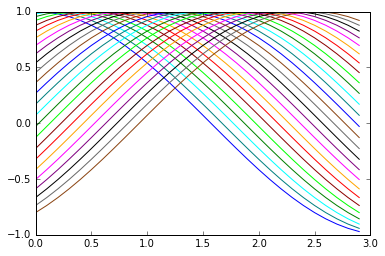

In [137]:
palette = ['blue', 'teal', 'cyan', 'green', 'lime', 'darkred', 'red',
           'orange', 'magenta', 'purple', 'black', 'dimgray', 'saddlebrown',
           'blue', 'teal', 'cyan', 'green', 'lime', 'darkred', 'red',
           'orange', 'magenta', 'purple', 'black', 'dimgray', 'saddlebrown']

x = np.arange(0, 3, 0.1)
for p in range(26):
    plt.plot(x, np.cos(x-p*0.1), color=palette[p])